<a href="https://colab.research.google.com/github/sofaemha/pengolahan-citra-digital/blob/main/26-Maret-2024/klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas PCD: Klasifkasi Gambar

Dengan dibuatnya tugas ini bertujuan untuk membangun sebuah model neural network yang dapat mengklasifikasikan gambar angka, seperti nol dan delapan. Tugas ini menggunakan fitur [Keras](https://www.tensorflow.org/guide/keras), sebuah API tingkat tinggi untuk membangun dan melakukan training model di TensorFlow.

## Persiapan dan Konfigurasi

Saat ini TensorFlow berada pada versi `2.x`, sebelum melakukan impor data alangkah baiknya menguji apakah versi aplikasi tersedia, menggunakan kode berikut :

In [3]:
try:
  # Inisialisasi versi dari TensorFlow
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Jika proses inisialisasi berhasil, selanjutnya adalah melakukan impor data dan fungsi yang diperlukan dengan mengeksekusi kode berikut :

In [4]:
# Pustaka utama
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow dan API Keras
import tensorflow
from tensorflow import keras

# Pustaka penunjang
import random
import numpy as numerik
import matplotlib.pyplot as matlab

def get_random(range=False, start=0, stop=10):
  if range:
    return random.randint(start, stop)
  else:
    return random.random()

# Mengecek versi TensorFlow
print(tensorflow.__version__)

2.15.0


## Konfigurasi Dataset

Tugas ini menggunakan dataset [MNIST Digits](https://keras.io/api/datasets/mnist/) yang memiliki 60,000 gambar hitam putih dalam 10 kategori angka. Tiap gambar menunjukan gambar dari satu tipe angka dalam resolusi rendah (28 x 28 pixel), seperti yang dapat dilihat disini :

<table>
  <tr><td>
    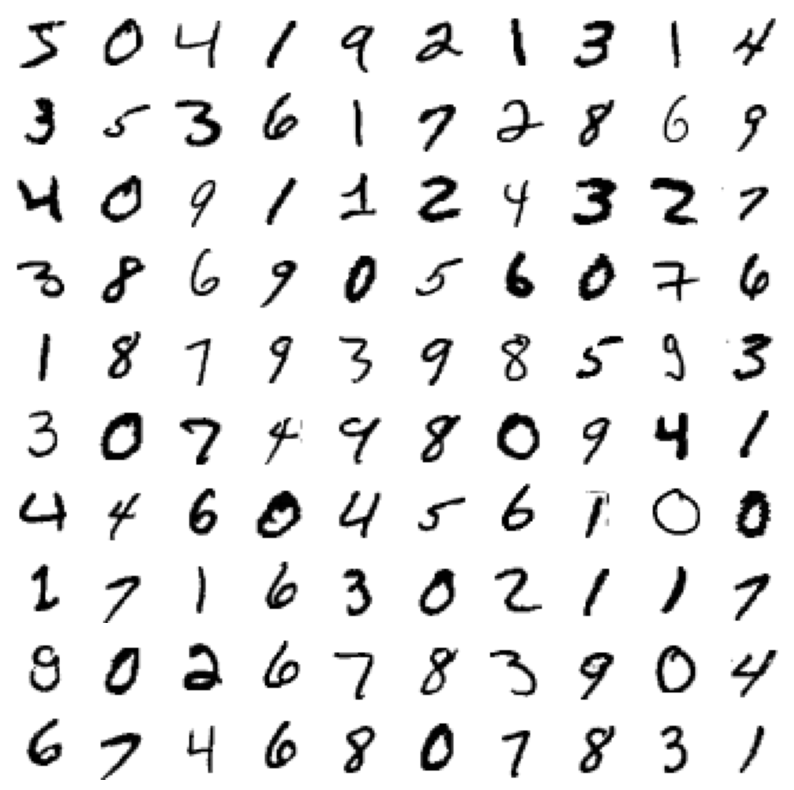
  </td></tr>
  <tr><td align="center">
    <b>Gambar 1.</b> <a href="https://keras.io/api/datasets/mnist/">Sampel MNIST dibuat otomatis oleh Matplotlib</a> (by Sofa eMHa).<br/>&nbsp;
  </td></tr>
</table>

Dataset MNIST terdiri atas gambar angka tulisan tangan (0, 1, 2, dsb) dalam format yang identik dengan gambar angka yang akan digunakan dalam dataset MNIST. Terdapat 60,000 gambar digunakan sebagai data train dari model neural network dan 10,000 gambar digunakan untuk mengevaluasi seberapa akurat model dapat mengklasifikasikan gambar.

Untuk mengakses dataset MNIST lakukan impor dan muat data MNIST langsung dari TensorFlow :

In [5]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Dataset yang telah di muat akan mengembalikan empat nilai NumPy arrays :

* Array `train_images` dan `train_labels` merupakan data yang digunakan oleh model untuk mempelajari *pattern*
* Model diuji menggunakan *test set*, yaitu array `test_images`, dan `test_labels`.

Tiap gambar merupakan array berukuran 28x28, dengan nilai pixel yang berkisar antara 0 sampai dengan 255. Label dari data merupakan array bertipe bilangan integer, yang memiliki rentang nilai dari 0 sampai dengan 9. Nilai ini memiliki korespondensi dengan kelas angka (0-9).

Setiap gambar memiliki satu label saja. Nama kelas tidak tersedia dalam dataset, untuk itu pada kode berikut ditujukan untuk membuat nama kelas yang berguna ketika akan melakukan plotting dari gambar tersebut.

In [6]:
nama_kelas = ' '.join(map(str,[i for i in range(10)])).split(' ')

print(nama_kelas)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Eksplorasi Data

Lakukan eksplorasi dari format dataset sebelum menggunakan data tersebut untuk membangun model. Kode berikut menunjukan bahwa terdapat 60,000 gambar di dalam training set, setiap gambar berukuran 28 x 28 pixel.

In [7]:
train_images.shape

(60000, 28, 28)

Selain terdapat 60,000 gambar, terdapat juga 60,000 label di dalam training set :

In [8]:
len(train_labels)

60000

Setiap label adalah bilangan integer antara 0 dan 9 :

In [9]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Dan memiliki tipe data NumPy int 8 :

In [10]:
type(train_labels[0])

numpy.uint8

Terdapat 10,000 gambar di dalam test set. Gambar ini juga direpresentasikan sebagai 28 x 28 pixel :

In [11]:
test_images.shape

(10000, 28, 28)

Dan test set mengandung 10,000 label gambar :

In [12]:
len(test_labels)

10000

## Pre-Processing Data

Data harus diolah terlebih dahulu sebelum digunakan untuk membangun model neural network. Jika Anda mengamati gambar pertama dalam training set, Anda akan melihat bahwa nilai pixel dari gambar memiliki rentang antara 0 sampai dengan 255 :

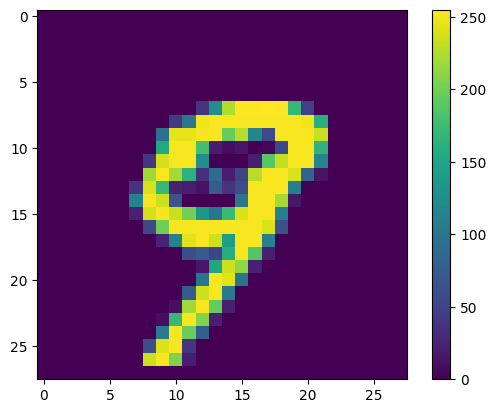

In [13]:
def show_colorbar(number, train_images):
  matlab.figure()
  matlab.imshow(train_images[number])
  matlab.colorbar()
  matlab.grid(False)
  matlab.show()

show_colorbar(get_random(True, 0, 100), train_images)

Nilai pixel ini akan diubah menjadi rentang 0 sampai dengan 1 sebelum menggunakannya sebagai input dari model neural network. Untuk melakukan hal tersebut, nilai tersebut harus dibagi dengan 255. Perlu diperhatika bahwa training set dan testing set harus diolah dengan cara yang sama :

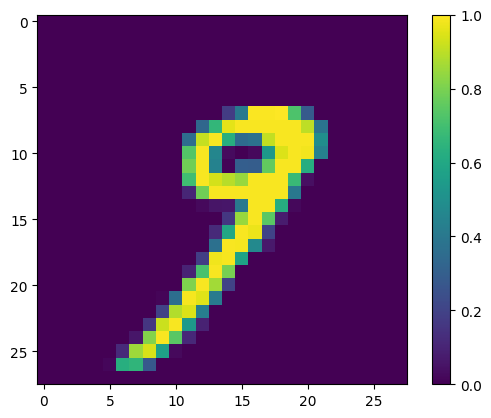

In [14]:
def range_trim(number, train_images, test_images):
  train_images = train_images / number
  show_colorbar(get_random(True, 0, 100), train_images)

range_trim(255.0, train_images, test_images)

Untuk memastikan bahwa data dalam format yang benar dan siap untuk membangun dan melatih model neural network, tampilkan 25 gambar pertama dari training set dan menampilkan nama kelas di bawah dari tiap gambar.

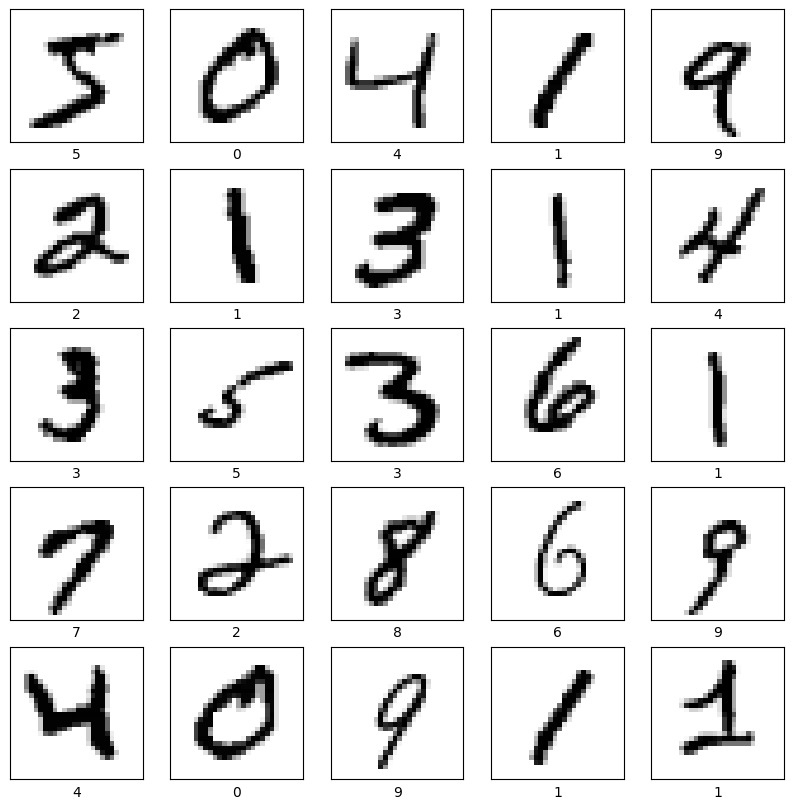

In [15]:
def show_data(index=25, size=5, border=True, label=True):
  matlab.figure(figsize=(10,10))
  for i in range(index):
    ax = matlab.subplot(size,size,i+1)
    matlab.xticks([])
    matlab.yticks([])
    matlab.grid(False)
    matlab.imshow(train_images[i], cmap=matlab.cm.binary)
    if label:
      matlab.xlabel(nama_kelas[train_labels[i]])
    if not border:
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
  matlab.show()

show_data()

## Membangun Model

Untuk dapat membuat sebuah model neural network, perlu dilakukan konfigurasi layer untuk model tersebut, sehingga proses kompilasi pada model dapat dilakukan. Tapi sebelum itu eksekusi kode pre-processing data secara global.

In [16]:
train_images = train_images / 255.0
test_images = test_images / 255.0
matlab.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

### Pengaturan Layer

Komponen utama dari neural network adalah *layer*. Layer mengekstraksi representasi dari data yang masuk ke dalam layer-layer tersebut. Harapannya, representasi tersebut berguna untuk mengatasi permasalahan yang ingin diselesaikan.

Kebanyakan deep learning terdiri atas penggabungan layer-layer sederhana. Kebanyakan layer, seperti `tf.keras.layers.Dense`, memiliki parameter-parameter yang dipelajari ketika proses training dijalankan.

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Layer pertama dalam model neural network ini, `tf.keras.layers.Flatten`, melakukan transformasi dari format gambar yang mulanya aray dua dimensi (28 x 28 pixel) menjadi aray satu dimensi (28 * 28 = 784 pixel). Bayangkan layer ini sebagai layar yang membuat pixel-pixel dalam gambar menjadi satu baris. Layer ini tidak memiliki parameter untuk dipelajari; layer ini hanya mengubah format dari data.

Setelah pixel diubah menjadi satu baris, model yang akan dibuat terdiri dari dua buah layer `tf.keras.layers.Dense`. Kedua layer ini terhubung secara penuh. Layer `Dense` yang pertama memiliki 128 node (atau neuron). Layer yang kedua (dan terakhir) memiliki 10 node *softmax* yang mengembalikan sebuah array dari 10 nilai probabilitas yang apabila dijumlahkan hasilnya adalah 1. Setiap node memiliki score yang mengindikasikan probabilitas bahwa gambar yang sedang diproses merupakan 1 dari 10 kelas label.

### Proses Kompilasi Model

Sebelum model siap untuk di training, model ini memerlukan beberapa pengaturan tambahan. Pengaturan ini ditambahkan ketika proses kompilasi :

* *loss function* — Fungsi ini menghitung seberapa akurat model ketika proses training dilakukan. Sehingga meminimalisir nilai kerugian dari fungsi ini untuk "mengarahkan" model ke arah yang benar.
* *Optimizer* — Optimizer mendefinisikan cara model untuk memperbarui modelnya berdasarkan data yang dilihat dan berdasarkan loss function-nya.
* *Metrics* — Bagian ini digunakan untuk memantau langkah-langkah dalam proses training dan testing. Dalam contoh ini, digunakan *akurasi*, perbandingan gambar yang diklasifikasikan dengan tepat oleh model.

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Proses Training Model

Melakukan training terhadap model neural network memerlukan beberapa langkah sebagai berikut :

1. Gunakan training data sebagai inputan untuk model. Dalam kasus ini, training data terdapat dalam array `train_images` dan `train_labels`.
2. Model akan mempelajari untuk mengasosiaskan antara gambar dan label.
3. Model membuat prediksi terhadap test set, dalam kasus ini, array `test_images`. Pastikan bahwa prediksi cocok dengan label yang terdapat di array `test_labels`.

Untuk memulai proses training, panggil method `model.fit`— dinamakan method fit karena method ini "membuat" model berdasarkan data training :

In [19]:
model.fit(
    train_images,
    train_labels,
    epochs=10
)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2568 - accuracy: 0.9261
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1156 - accuracy: 0.9658
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0790 - accuracy: 0.9754
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0589 - accuracy: 0.9824
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0460 - accuracy: 0.9856
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0359 - accuracy: 0.9889
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0283 - accuracy: 0.9916
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0230 - accuracy: 0.9934
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0188 - accuracy: 0.9942
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0

Ketika proses training model sedang dilakukan, *loss metrics* dan *accuracy metrics* ditampilkan. Model ini mencapai akurasi sekitar 0.88 (atau 88%) terhadap data training.

## Evaluasi nilai dari akurasi

Selanjutnya, bandingkan bagaimana performansi dari model terhadap data test :

In [20]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc, " | ", round(test_acc * 100, 2), "%")

313/313 - 1s - loss: 0.0737 - accuracy: 0.9789 - 742ms/epoch - 2ms/step

Test accuracy: 0.9789000153541565  |  97.89 %


Hasilnya adalah akurasi dari data test sedikit lebih kecil dibandingkan dengan akurasi model terhadap data training. Perbedaan antara akurasi dari data training dan data test memperlihatkan *overfitting*. Overfitting terjadi ketika performansi dari model machine learning lebih buruk untuk data baru yang belum pernah dilihat sebelumnya dibandingkan dengan data training.

## Membuat Prediksi

Dengan model yang telah dilatih menggunakan data training, dapat digunakan untuk memprediksi berbagai gambar.

In [21]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Disini, model telah memprediksi label dari tiap gambar yang terdapat di data test. Mari lihat prediksi pertama dari model :

In [22]:
predictions[0]

array([4.8478898e-11, 2.6312684e-13, 2.3991554e-08, 9.1537468e-06,
       1.0438786e-14, 6.4997308e-10, 7.8177967e-19, 9.9998921e-01,
       4.8088384e-07, 1.1231240e-06], dtype=float32)

Prediksi dari gambar pertama dalam data test adalah array dengan 10 angka. Prediksi ini memperlihatkan "*confidence*" dari model terhadap 10 jenis digit nomor. Kemudian dapat dilihat label mana yang memiliki nilai *confidence* yang tinggi :

In [23]:
numerik.argmax(predictions[0])

7

Jadi, model memprediksi bahwa gambar tersebut adalah angka 7, atau `nama_kelas[7]`. Dengan meninjau label test, dapat dilihat bahwa klasifikasi ini benar :

In [24]:
test_labels[0]

7

Gambar berikut digunakan untuk melihat seluruh set dari prediksi 10 kelas.

In [37]:
def plot_image(index, predictions, label, image):
  predictions, label, image = predictions, label[index], image[index]

  matlab.grid(False)
  matlab.xticks([])
  matlab.yticks([])
  matlab.imshow(image, cmap=matlab.cm.binary)

  predicted_label = numerik.argmax(predictions)

  if predicted_label == label:
    color = 'blue'
  else:
    color = 'red'

  matlab.xlabel(
    "{} {:2.0f}% ({}) [{}]"
    .format(
        nama_kelas[predicted_label],
        100*numerik.max(predictions),
        nama_kelas[label],
        index
    ), color=color
  )

def plot_value_array(index, predictions, label):
  predictions, label = predictions, label[index]

  matlab.grid(False)
  matlab.xticks(range(10))
  matlab.yticks([])
  matlab.ylim([0, 1])

  predicted_label = numerik.argmax(predictions)

  plot = matlab.bar(range(10), predictions, color="#777777")
  plot[predicted_label].set_color('red')
  plot[label].set_color('blue')

def show_prediction(number):
  matlab.figure(figsize=(6,3))
  matlab.subplot(1,2,1)
  plot_image(number, predictions[number], test_labels, test_images)
  matlab.subplot(1,2,2)
  plot_value_array(number, predictions[number],  test_labels)
  matlab.show()

def show_range_prediction(column, row):
  total = column * row
  matlab.figure(figsize=(2 * 2 * column, 2 * row))
  for i in range(total):
    matlab.subplot(row, 2 * column, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)
    matlab.subplot(row, 2 * column, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)
  matlab.tight_layout()
  matlab.show()

Mari lihat gambar ke-0, prediksi, dan array prediksi. Label prediksi yang tepat berwarna biru dan label prediksi yang salah akan berwarna merah. Bilangan yang ada memberikan presentase (dari 100) untuk label yang diprediksi.

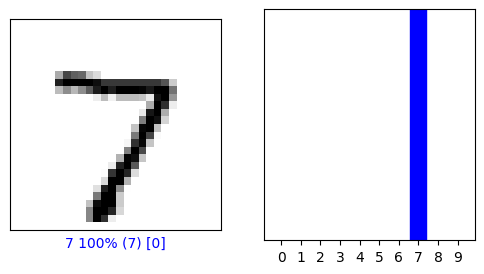

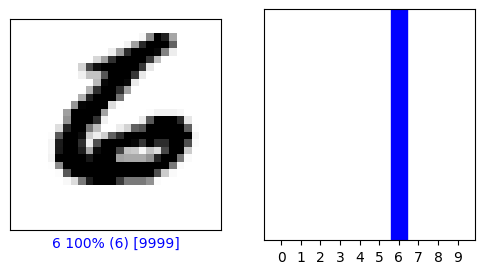

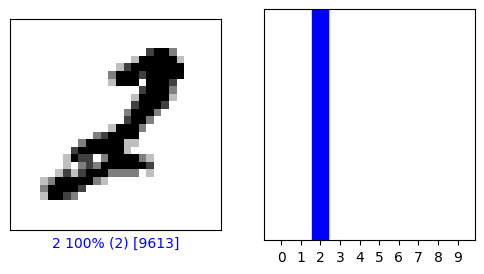

In [52]:
show_prediction(0)
show_prediction(9999)
show_prediction(get_random(True, stop=9999))

Mari buat plot beberapa gambar dengan prediksinya. Perhatikan bahwa model dapat salah meskipun model sangat percaya diri dengan prediksinya.

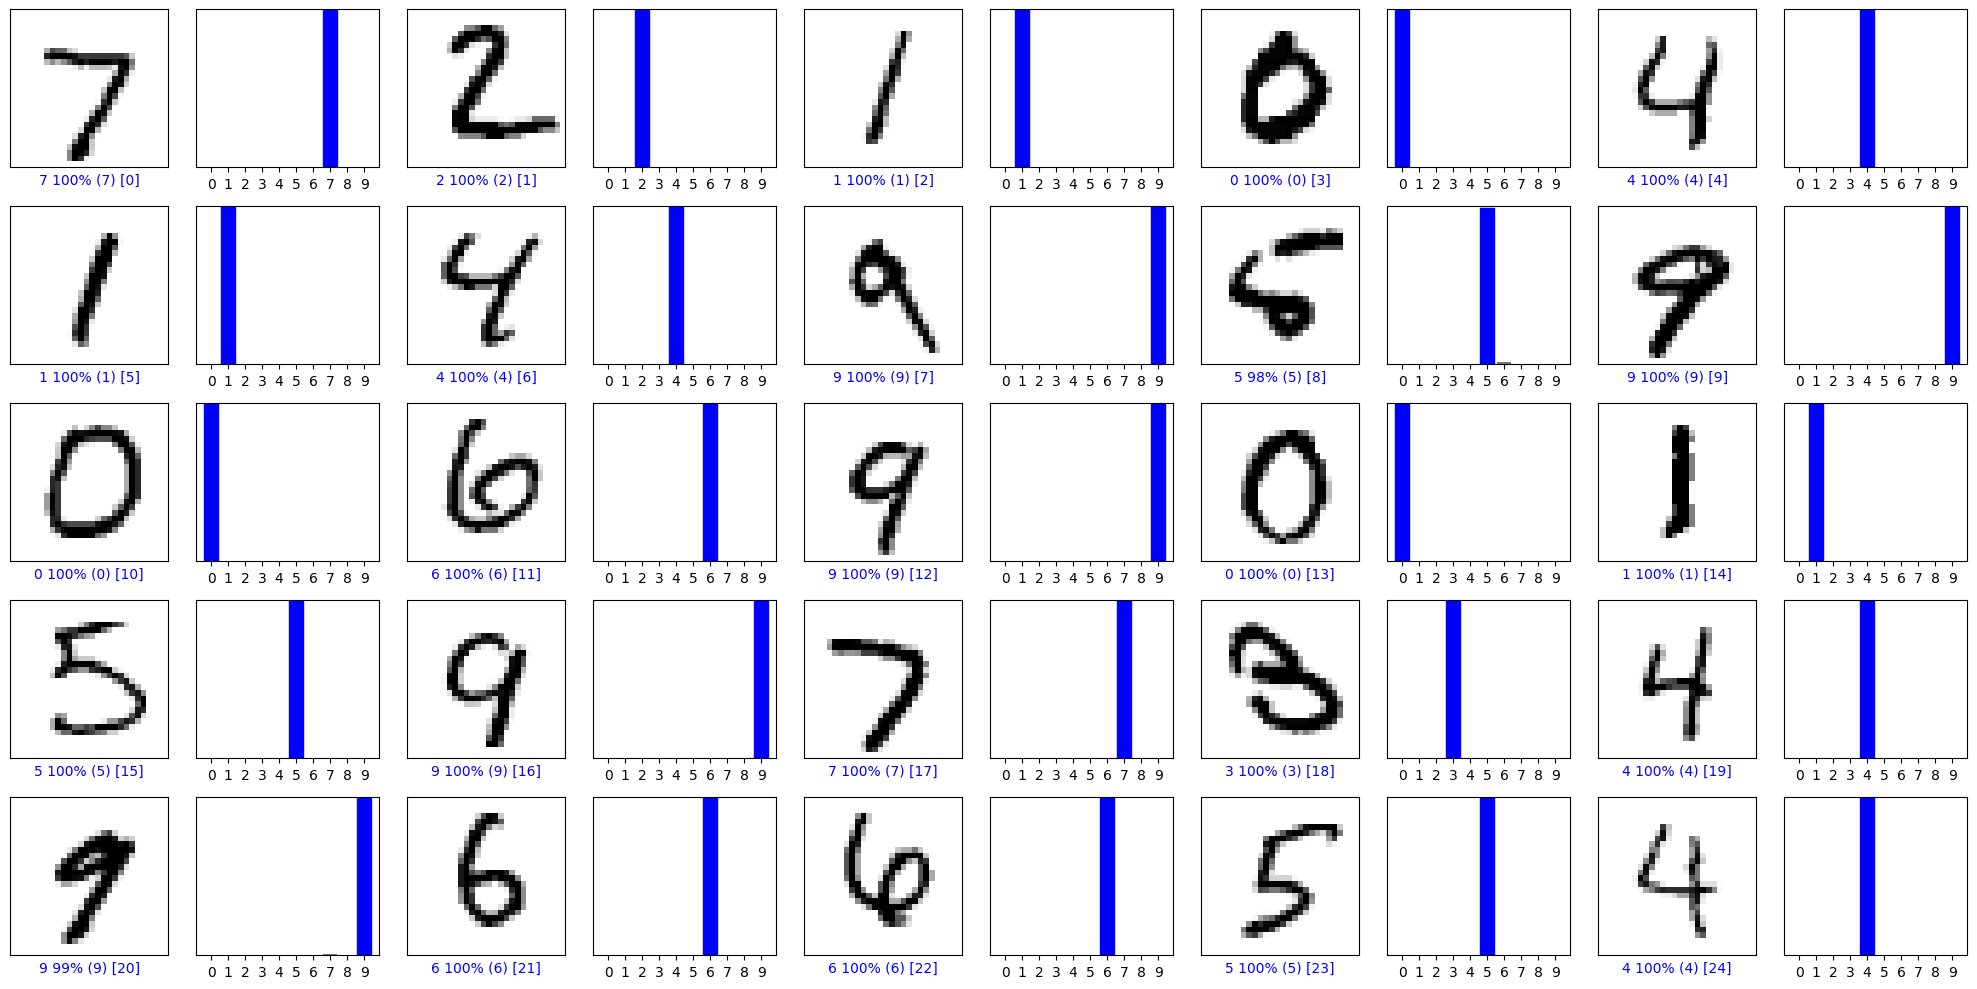

In [51]:
show_range_prediction(5, 5)

Selanjutnya, gunakan model yang telah dibuat untuk membuat prediksi terhadap sebuah gambar.

In [45]:
image = test_images[1]

print(image.shape)

(28, 28)


Model-model `tf.keras` dioptimalisasi untuk membuat prediksi dalam sebuah *batch*, atau koleksi, dari contoh-contoh sekaligus. Sehingga, meskipun menggunakan satu gambar, juga harus menambahkan gambar tersebut ke dalam list :

In [46]:
image = (numerik.expand_dims(image,0))

print(image.shape)

(1, 28, 28)


Sekarang prediksi label yang tepat untuk gambar ini :

In [47]:
predictions_single = model.predict(image)

print(predictions_single)

1/1 [==============================] - 0s 125ms/step
[[5.9043583e-09 2.6324938e-07 9.9999952e-01 1.2412603e-07 5.4563392e-20
  4.7537352e-08 3.5394504e-10 4.7404691e-16 9.1642125e-09 6.6650389e-17]]


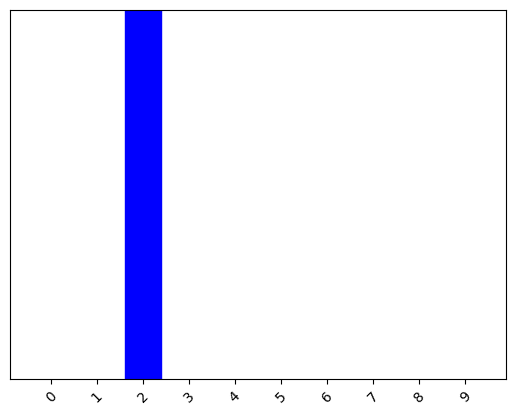

In [49]:
plot_value_array(1, predictions_single[0], test_labels)
_ = matlab.xticks(range(10), nama_kelas, rotation=45)

Dalam hal ini  `model.predict` mengembalikan list dari list—satu list untuk setiap gambar di dalam batch dari data. Lakukan prediksi untuk gambar dalam batch ini :

In [50]:
numerik.argmax(predictions_single[0])

2

Dan model memprediksi label sesuai yang diharapkan.